# Advanced Model - Random Forest

This notebook implements an **advanced model** using Random Forest to predict bakery sales.

## Why Random Forest?
- **Handles Non-linearity**: Captures complex patterns
- **Feature Importance**: Shows which features matter most
- **Robust**: Less prone to overfitting
- **Ensemble Method**: Combines 100 decision trees

---
## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)

print("✓ Libraries imported successfully!")
print("\nAdvanced Model: Random Forest")

✓ Libraries imported successfully!

Advanced Model: Random Forest


---
## 2. Load Data

In [2]:
# Load dataset
df = pd.read_csv('../0_DataPreparation/0.3 Additional Features/complete_dataset_with_additional_features.csv')
df['date'] = pd.to_datetime(df['date'])

print("="*80)
print("DATA LOADED")
print("="*80)
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

df.head()

DATA LOADED

Shape: 11,164 rows × 50 columns
Date range: 2013-07-01 to 2019-07-30


,id,date,Warengruppe,umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,Is_Holiday,Day_Before_Holiday,Day_After_Holiday,Is_Vacation,Vacation_Type,day_of_the_week,month,is_weekend,days_to_weekend,bewoelkung_category,wettercode_category,season,temperature_category,temp_change_1d,temp_trend_3d,umsatz_ma7,umsatz_ma14,umsatz_volatility_7d,umsatz_sum_7d,umsatz_lag1,umsatz_lag7,umsatz_pct_change,umsatz_pct_change_lag1,season_numeric,is_weekend_int,weekend_season_interaction,weekend_season_category,holiday_temp_interaction,holiday_temp_category,day_before_holiday_int,day_before_holiday_weekend_interaction,day_before_holiday_weekend_category,KielerWoche_binary,kielerweek_temp_interaction,kielerweek_temp_category,temp_season_interaction,temp_season_category,weekend_temp_interaction,weekend_temp_category,bewoelkung_weekend_interaction,bewoelkung_weekend_category
0,1307011.0,2013-07-01,1.0,148.828353,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,NaN,NaN,148.828353,148.828353,NaN,148.828353,NaN,NaN,NaN,NaN,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy
1,1307012.0,2013-07-01,2.0,535.856285,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,0.0,NaN,342.342319,342.342319,273.670075,684.684638,148.828353,NaN,2.600499,NaN,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy
2,1307013.0,2013-07-01,3.0,201.198426,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,0.0,NaN,295.294355,295.294355,209.971874,885.883064,535.856285,NaN,-0.624529,2.600499,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy
3,1307014.0,2013-07-01,4.0,65.890169,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,0.0,0.0,237.943308,237.943308,206.273351,951.773232,201.198426,NaN,-0.672512,-0.624529,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy
4,1307015.0,2013-07-01,5.0,317.475875,NaN,6.0,17.8375,15.0,20.0,0,0,0,1,Summer,0,7,False,5,Very cloudy,Drizzle (not freezing) or snow grains,Summer,Medium,0.0,0.0,253.849821,253.849821,182.144468,1269.249107,65.890169,NaN,3.818259,-0.672512,3,0,0,Weekday_Summer,0.0,No_Holiday,0,0,Regular_Day,0,0.0,No_KielerWoche,9.0,Medium_Summer,0.0,Weekday_Medium,0.0,Weekday_Very cloudy


---
## 3. Data Cleaning

In [3]:
print("Cleaning data...\n")

# Separate data
df_with_sales = df[df['umsatz'].notna()].copy()
df_without_sales = df[df['umsatz'].isna()].copy()

print(f"Training data: {len(df_with_sales):,} rows")
print(f"Test data: {len(df_without_sales):,} rows")

# Drop lag features
lag_cols = [col for col in df.columns if any(x in col.lower() for x in ['lag', '_ma', 'volatility', 'pct_change', 'sum_7d'])]
if 'id' in df.columns:
    lag_cols.append('id')

print(f"\nDropping {len(lag_cols)} lag features")

df_with_sales = df_with_sales.drop(columns=lag_cols, errors='ignore')
df_without_sales = df_without_sales.drop(columns=lag_cols, errors='ignore')

# Fill missing values
for col in df_with_sales.columns:
    if df_with_sales[col].isnull().sum() > 0:
        if df_with_sales[col].dtype in ['float64', 'int64']:
            fill_val = df_with_sales[col].median()
            df_with_sales[col].fillna(fill_val, inplace=True)
            df_without_sales[col].fillna(fill_val, inplace=True)
        else:
            fill_val = 'Unknown'
            df_with_sales[col].fillna(fill_val, inplace=True)
            df_without_sales[col].fillna(fill_val, inplace=True)

print(f"✓ Data cleaned!")

Cleaning data...

Training data: 9,334 rows
Test data: 1,830 rows

Dropping 9 lag features
✓ Data cleaned!


---
## 4. Split Data

In [4]:
# Split chronologically
train_data = df_with_sales[df_with_sales['date'] < '2018-01-01'].copy()
val_data = df_with_sales[df_with_sales['date'] >= '2018-01-01'].copy()
test_data = df_without_sales.copy()

print("Data Split:")
print(f"  Training:   {len(train_data):,} rows | {train_data['date'].min().date()} to {train_data['date'].max().date()}")
print(f"  Validation: {len(val_data):,} rows | {val_data['date'].min().date()} to {val_data['date'].max().date()}")
print(f"  Test:       {len(test_data):,} rows | {test_data['date'].min().date()} to {test_data['date'].max().date()}")

Data Split:
  Training:   8,294 rows | 2013-07-01 to 2017-12-31
  Validation: 1,040 rows | 2018-01-02 to 2018-07-31
  Test:       1,830 rows | 2018-08-01 to 2019-07-30


---
## 5. Prepare Features

In [5]:
# Exclude columns
exclude_cols = ['date', 'umsatz']

# Get categorical columns
categorical_cols = train_data.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

print(f"Categorical columns: {len(categorical_cols)}")

# One-hot encoding
print(f"\nApplying One-Hot Encoding...")

all_data = pd.concat([train_data, val_data, test_data], ignore_index=True)
all_encoded = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True, dtype=int)

# Split back
train_encoded = all_encoded.iloc[:len(train_data)].copy()
val_encoded = all_encoded.iloc[len(train_data):len(train_data)+len(val_data)].copy()
test_encoded = all_encoded.iloc[len(train_data)+len(val_data):].copy()

# Feature matrices
feature_cols = [col for col in train_encoded.columns if col not in exclude_cols]

X_train = train_encoded[feature_cols]
X_val = val_encoded[feature_cols]
X_test = test_encoded[feature_cols]

y_train = train_encoded['umsatz']
y_val = val_encoded['umsatz']

print(f"\nFeature matrices created:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"\n✓ Ready for modeling!")

Categorical columns: 13

Applying One-Hot Encoding...

Feature matrices created:
  X_train: (8294, 117)
  X_val:   (1040, 117)
  X_test:  (1830, 117)

✓ Ready for modeling!


---
## 6. Helper Functions

In [6]:
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

def adjusted_r2(r2, n_samples, n_features):
    """Calculate Adjusted R²"""
    adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
    return adj_r2

print("✓ Helper functions ready")

✓ Helper functions ready


---
## 7. Train Random Forest Model

In [7]:
print("="*80)
print("TRAINING ADVANCED MODEL")
print("="*80)
print("\nThis may take 2-3 minutes...\n")

# Create model with hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=100,        # 100 trees
    max_depth=20,            # Max tree depth
    min_samples_split=10,    # Min samples to split
    min_samples_leaf=5,      # Min samples in leaf
    random_state=42,
    n_jobs=-1,               # Use all CPU cores
    verbose=1                # Show progress
)

# Train model
rf_model.fit(X_train, y_train)

print("\n✓ Model trained successfully!")

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

print(f"Predictions generated")

TRAINING ADVANCED MODEL

This may take 2-3 minutes...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



✓ Model trained successfully!
Predictions generated


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


---
## 8. Evaluate Model

In [8]:
# Calculate metrics
train_mape = calculate_mape(y_train, y_train_pred)
val_mape = calculate_mape(y_val, y_val_pred)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
val_adj_r2 = adjusted_r2(val_r2, len(X_val), X_val.shape[1])

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

# Display results
print("="*80)
print("ADVANCED MODEL - EVALUATION RESULTS")
print("="*80)

print(f"\n{'Metric':20s} {'Training':>15s} {'Validation':>15s}")
print("-"*50)
print(f"{'MAPE':20s} {train_mape:14.2f}% {val_mape:14.2f}%")
print(f"{'R²':20s} {train_r2:15.4f} {val_r2:15.4f}")
print(f"{'Adjusted R²':20s} {train_adj_r2:15.4f} {val_adj_r2:15.4f}")
print(f"{'MAE (€)':20s} {train_mae:15.2f} {val_mae:15.2f}")

print(f"\n{'='*80}")

ADVANCED MODEL - EVALUATION RESULTS

Metric                      Training      Validation
--------------------------------------------------
MAPE                          13.42%          20.39%
R²                            0.9033          0.8497
Adjusted R²                   0.9019          0.8306
MAE (€)                        23.73           35.46



---
## 9. Feature Importance

Top 15 Most Important Features:
                          Feature  Importance
                      Warengruppe    0.712583
                    season_Summer    0.081855
                  day_of_the_week    0.034921
                       Temperatur    0.032383
                            month    0.016915
                  days_to_weekend    0.015439
              Windgeschwindigkeit    0.009542
                      Is_Vacation    0.008855
            Vacation_Type_Unknown    0.008187
weekend_temp_category_Weekday_Low    0.006593
                       Wettercode    0.006138
                    temp_trend_3d    0.006001
       weekend_season_interaction    0.005448
          Vacation_Type_Christmas    0.005198
             Vacation_Type_Summer    0.005054


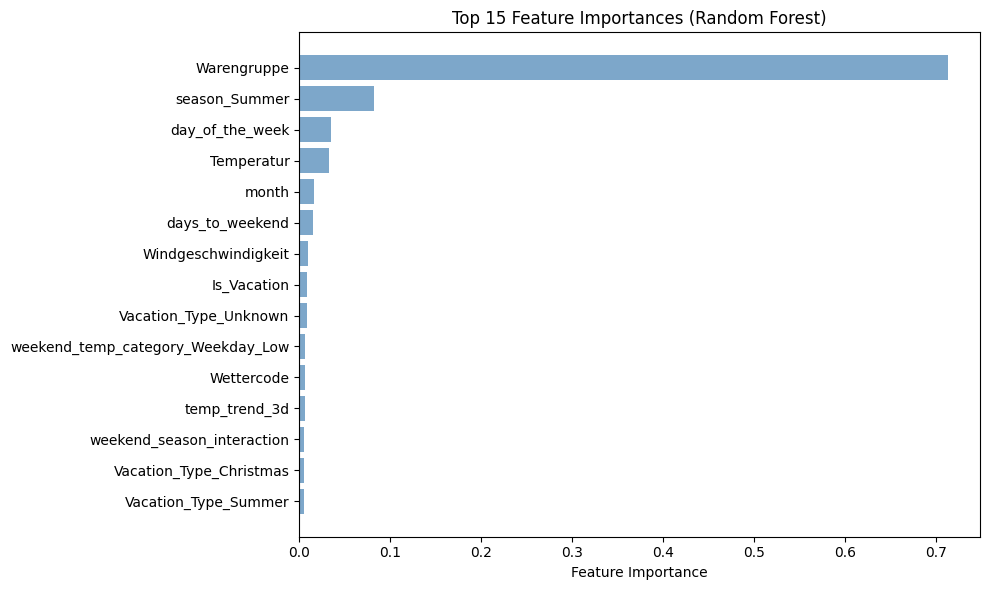


✓ Feature importance saved as 'feature_importance.png'


In [9]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize top features
plt.figure(figsize=(10, 6))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['Importance'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_15)), [f[:40] for f in top_15['Feature']])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance saved as 'feature_importance.png'")

---
## 10. Visualizations

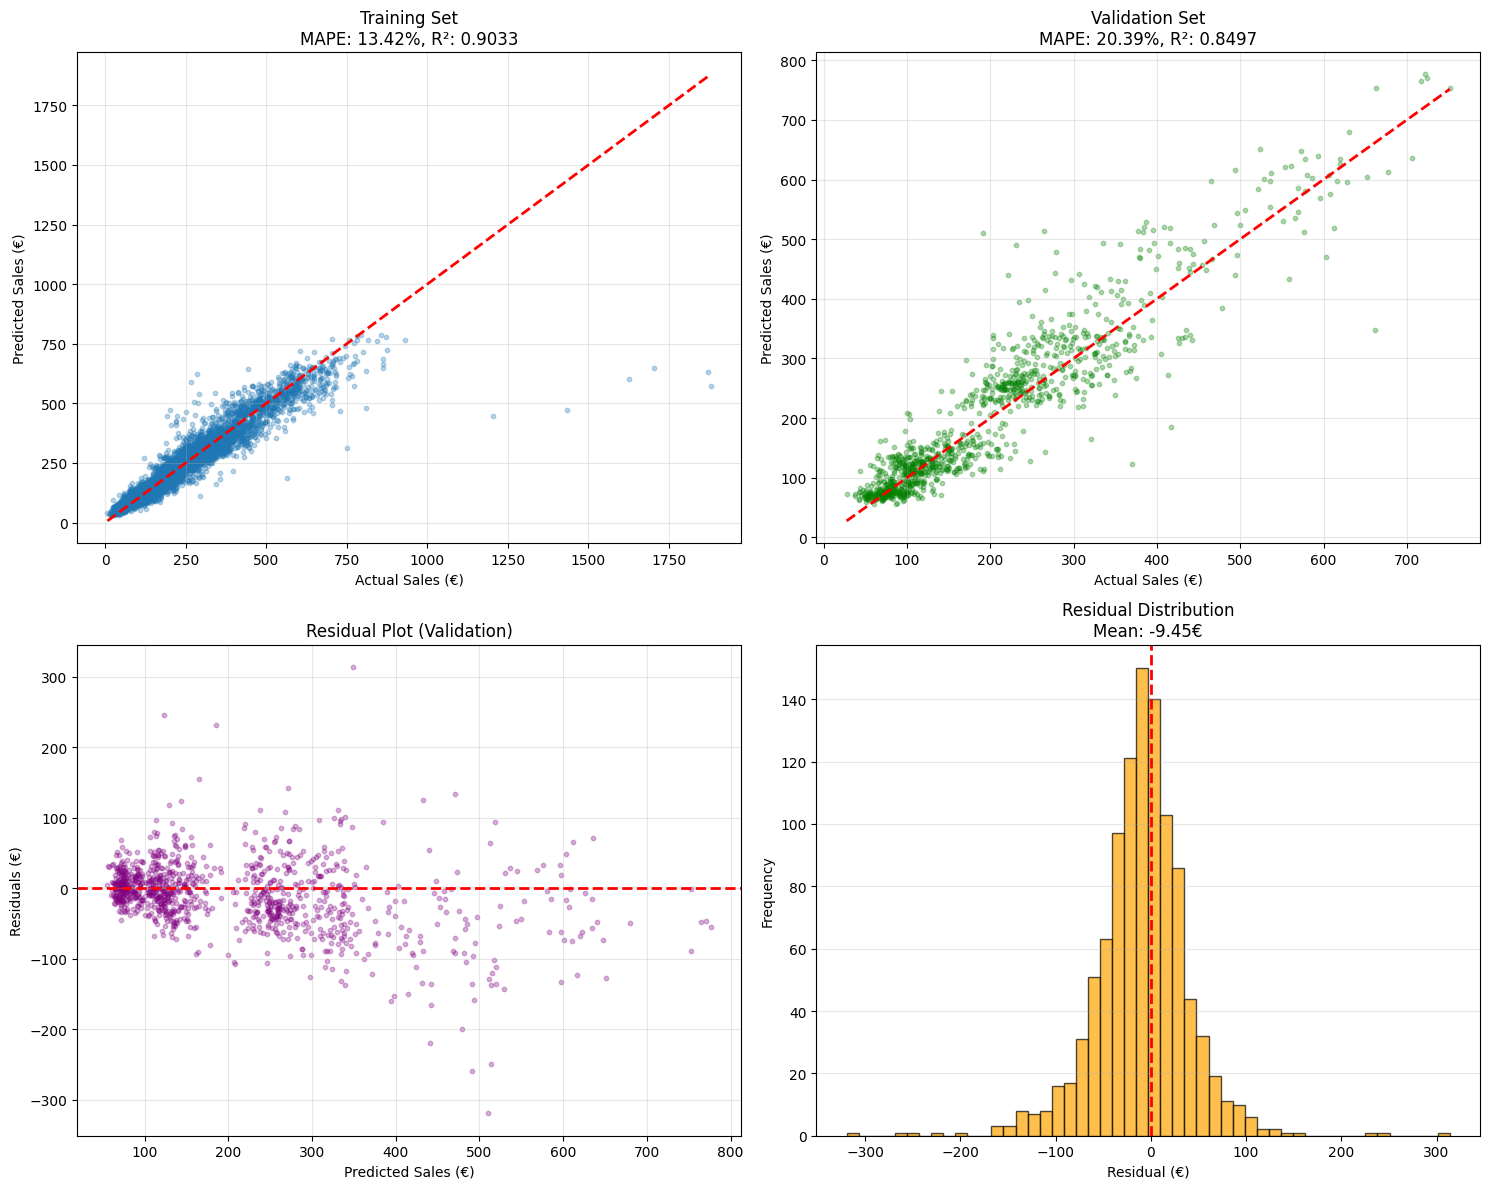

✓ Visualizations saved as 'advanced_model_results.png'


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted (Training)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.3, s=10)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales (€)')
axes[0, 0].set_ylabel('Predicted Sales (€)')
axes[0, 0].set_title(f'Training Set\nMAPE: {train_mape:.2f}%, R²: {train_r2:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Validation)
axes[0, 1].scatter(y_val, y_val_pred, alpha=0.3, s=10, color='green')
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Sales (€)')
axes[0, 1].set_ylabel('Predicted Sales (€)')
axes[0, 1].set_title(f'Validation Set\nMAPE: {val_mape:.2f}%, R²: {val_r2:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals
residuals = y_val - y_val_pred
axes[1, 0].scatter(y_val_pred, residuals, alpha=0.3, s=10, color='purple')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Sales (€)')
axes[1, 0].set_ylabel('Residuals (€)')
axes[1, 0].set_title('Residual Plot (Validation)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Error distribution
axes[1, 1].hist(residuals, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residual (€)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Residual Distribution\nMean: {residuals.mean():.2f}€')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('advanced_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'advanced_model_results.png'")

---
## 11. Generate Predictions for Test Set

In [11]:
print("Generating predictions for test set...\n")

# Make predictions
test_predictions = rf_model.predict(X_test)

# Create submission file
submission = test_encoded[['date', 'Warengruppe']].copy()
submission['umsatz_predicted'] = test_predictions
submission = submission.sort_values(['date', 'Warengruppe']).reset_index(drop=True)

print(f"Test Set Predictions:")
print(f"  Total predictions: {len(submission):,}")
print(f"  Mean predicted sales: €{submission['umsatz_predicted'].mean():.2f}")
print(f"  Date range: {submission['date'].min().date()} to {submission['date'].max().date()}")

print(f"\nFirst 10 predictions:")
print(submission.head(10))

# Save
submission.to_csv('advanced_predictions.csv', index=False)
print(f"\n✓ Saved to: advanced_predictions.csv")

Generating predictions for test set...

Test Set Predictions:
  Total predictions: 1,830
  Mean predicted sales: €207.95
  Date range: 2018-08-01 to 2019-07-30

First 10 predictions:
        date  Warengruppe  umsatz_predicted
0 2018-08-01          1.0        136.999957
1 2018-08-01          2.0        583.071405
2 2018-08-01          3.0        266.625633
3 2018-08-01          4.0         80.814310
4 2018-08-01          5.0        298.356704
5 2018-08-02          1.0        133.577005
6 2018-08-02          2.0        555.758981
7 2018-08-02          3.0        244.916243
8 2018-08-02          4.0         72.946807
9 2018-08-02          5.0        298.349652

✓ Saved to: advanced_predictions.csv


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


---
## 12. Compare with Baseline (if available)

In [12]:
# Try to load baseline results for comparison
try:
    baseline_pred = pd.read_csv('../2_BaselineModel/baseline_predictions.csv')
    
    print("Baseline predictions loaded for comparison")
    print(f"\nBaseline mean prediction: €{baseline_pred['umsatz_predicted'].mean():.2f}")
    print(f"Advanced mean prediction: €{submission['umsatz_predicted'].mean():.2f}")
    print(f"\nDifference: €{submission['umsatz_predicted'].mean() - baseline_pred['umsatz_predicted'].mean():.2f}")
    
except:
    print("Baseline predictions not found (run baseline model first for comparison)")

Baseline predictions loaded for comparison

Baseline mean prediction: €208.78
Advanced mean prediction: €207.95

Difference: €-0.83


---
## 13. Summary

In [13]:
print("="*80)
print("ADVANCED MODEL - SUMMARY")
print("="*80)

print(f"\n📊 MODEL: Random Forest")
print(f"   Trees: 100")
print(f"   Max depth: 20")
print(f"   Features: {len(feature_cols)}")
print(f"   Training samples: {len(X_train):,}")

print(f"\n📈 PERFORMANCE (Validation Set):")
print(f"   MAPE: {val_mape:.2f}%")
print(f"   R²: {val_r2:.4f}")
print(f"   Adjusted R²: {val_adj_r2:.4f}")
print(f"   MAE: €{val_mae:.2f}")

print(f"\n✅ OUTPUTS:")
print(f"   ✓ advanced_predictions.csv - Test predictions")
print(f"   ✓ advanced_model_results.png - Performance visualizations")
print(f"   ✓ feature_importance.png - Top features chart")

print(f"\n📝 KEY FINDINGS:")
print(f"   The Random Forest model explains {val_r2*100:.1f}% of variance in sales.")
print(f"   Average prediction error is {val_mape:.1f}%.")
print(f"   Top feature: {feature_importance.iloc[0]['Feature']}")

print(f"\n" + "="*80)
print(f"✅ ADVANCED MODEL COMPLETE!")
print(f"="*80)

ADVANCED MODEL - SUMMARY

📊 MODEL: Random Forest
   Trees: 100
   Max depth: 20
   Features: 117
   Training samples: 8,294

📈 PERFORMANCE (Validation Set):
   MAPE: 20.39%
   R²: 0.8497
   Adjusted R²: 0.8306
   MAE: €35.46

✅ OUTPUTS:
   ✓ advanced_predictions.csv - Test predictions
   ✓ advanced_model_results.png - Performance visualizations
   ✓ feature_importance.png - Top features chart

📝 KEY FINDINGS:
   The Random Forest model explains 85.0% of variance in sales.
   Average prediction error is 20.4%.
   Top feature: Warengruppe

✅ ADVANCED MODEL COMPLETE!
